<a href="https://colab.research.google.com/github/DanieleAngioni97/CV_Project/blob/main/Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

# **Data Preparation**

In [5]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

MAIN_PATH = "/content/drive/My Drive/Colab_Notebooks/CV_Project"
# N_SAMPLES_TRAIN = 2000
# N_SAMPLES_VALID = 1000

df_train = pd.read_csv(MAIN_PATH + "/training_list.csv", names=['filename', 'x', 'y', 'u', 'v', 'room'])
df_train = df_train[['filename','x', 'y', 'u', 'v']]
df_train = df_train

df_validation = pd.read_csv(MAIN_PATH + "/validation_list.csv", names=['filename', 'x', 'y', 'u', 'v', 'room'])
df_validation = df_validation[['filename','x', 'y', 'u', 'v']]
df_validation = df_validation

values_to_predict = ['x', 'y', 'u', 'v']

IMG_SIZE = 128
BATCH_SIZE = 512

#Try std normalization and zero mean dataset, 
#learn std and mean from train and use for validation
#shuffle = True by default

train_dataset = ImageDataGenerator(rescale = 1./255) #map data in the range 0-1
train_dataset = train_dataset.flow_from_dataframe(
    dataframe = df_train,
    directory = MAIN_PATH + "/images",
    x_col = "filename",
    y_col = values_to_predict,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = "raw")

validation_dataset = ImageDataGenerator(rescale = 1./255) #map data in the range 0-1
validation_dataset = validation_dataset.flow_from_dataframe(
    dataframe = df_validation,
    directory = MAIN_PATH + "/images",
    x_col = "filename",
    y_col = values_to_predict,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = "raw")

Found 10259 validated image filenames.
Found 3101 validated image filenames.


In [ ]:
print(df_validation.shape)

(3101, 5)


# **Visualizing some images**

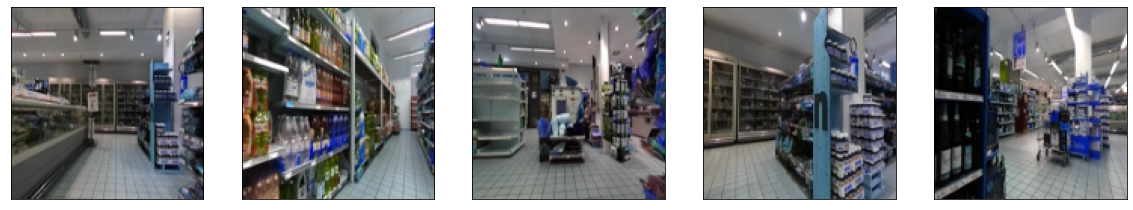

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow #used because cv2.imshow get crushed in colab

N_IMAGES = 5    #number of images to be visualized

train = df_train.to_numpy()
files_train = train[:,0]
np.random.shuffle(files_train)

x_train = np.zeros((N_IMAGES, IMG_SIZE, IMG_SIZE, 3))


for i,file_name in enumerate(files_train[:N_IMAGES]):
    img = cv2.imread(MAIN_PATH + "/images/" + file_name)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    x_train[i,:,:,:] = img/255
  
  
plt.figure(figsize=(20, 10))
for i in range(N_IMAGES):
    ax = plt.subplot(2, N_IMAGES, i+1)
    plt.imshow(x_train[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [ ]:
print(files_train)

['2L010440.jpg' '1L010820.jpg' '1L020300.jpg' ... '1L036440.jpg'
 '4L017600.jpg' '050520.jpg']


# **Training the model**

In [7]:
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.layers import Dense, BatchNormalization, Dropout, ReLU
from keras.models import Sequential
from keras.optimizers import Adam
from keras.losses import MeanSquaredError

model = Sequential([
            Conv2D(16, (3,3), activation = 'relu', padding='same',
                input_shape = (IMG_SIZE,IMG_SIZE,3)),
            MaxPooling2D((2, 2), padding='same'),#64x64x16
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2), padding='same'),#32x32x32
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2), padding='same'),#16x16x64
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2), padding='same'),#32x32x128
            Flatten(),
            Dense(4)                                       
])

# model = Sequential([
#             Conv2D(16, (3,3), padding='same',
#                 input_shape = (IMG_SIZE,IMG_SIZE,3)),          
#             # Conv2D(16, (5, 5), activation='relu', padding='same'),
#             BatchNormalization(),
#             ReLU(),
#             Dropout(rate=0.4),
#             MaxPooling2D((2, 2), padding='same'),

#             Conv2D(32, (3, 2), padding='same'),
#             # Conv2D(32, (3, 3), activation='relu', padding='same'),
#             BatchNormalization(),
#             ReLU(),
#             Dropout(rate=0.5),
#             MaxPooling2D((2, 2), padding='same'),

#             Conv2D(32, (3, 3), padding='same'),
#             # Conv2D(64, (3, 3), activation='relu', padding='same'),
#             BatchNormalization(),
#             ReLU(),
#             Dropout(rate=0.6),
#             MaxPooling2D((2, 2), padding='same'),

#             Conv2D(64, (3, 3), padding='same'),
#             BatchNormalization(),
#             ReLU(),
#             Dropout(rate=0.7),
#             MaxPooling2D((2, 2), padding='same'),

#             Conv2D(64, (3, 3), padding='same'),
#             BatchNormalization(),
#             ReLU(),
#             Dropout(rate=0.8),
#             MaxPooling2D((2, 2), padding='same'),

#             Conv2D(256, (3, 3), padding='same'),
#             BatchNormalization(),
#             ReLU(),
#             Dropout(rate=0.9),
#             MaxPooling2D((2, 2), padding='same'),

#             Flatten(),
#             Dense(4),
#             BatchNormalization(),
#             ReLU(),
#             Dropout(rate=0.9),
#             # Dense(512),
#             # Dense(4) #Linear activation to obtain full range [-inf, +inf] bc of regression
# ])

model.summary()

optim = Adam(learning_rate=0.001)
loss = MeanSquaredError()
model.compile(optimizer=optim, loss=loss)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       7

In [11]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
filepath = "/content/drive/My Drive/Colab_Notebooks/CV_Project/saved_models/"
filepath = filepath + "weights-improvement-{epoch:02d}-{val_loss:2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor="val_loss", verbose=1, 
                             save_best_only = True, mode = "min")

callbacks_list = [checkpoint]

history = model.fit(train_dataset,
                    epochs=20,
                    steps_per_epoch = df_train.shape[0]/BATCH_SIZE,
                    validation_steps = df_validation.shape[0]/BATCH_SIZE,
                    verbose=1,
                    validation_data = validation_dataset,
                    workers = 8)



Epoch 1/20
21/20 [===============================] - 645s 31s/step - loss: 41.9737 - val_loss: 37.2090
Epoch 2/20
21/20 [===============================] - 21s 992ms/step - loss: 32.0803 - val_loss: 32.3723
Epoch 3/20
21/20 [===============================] - 21s 977ms/step - loss: 26.5857 - val_loss: 26.1832
Epoch 4/20
21/20 [===============================] - 20s 972ms/step - loss: 24.5213 - val_loss: 25.5802
Epoch 5/20
21/20 [===============================] - 20s 974ms/step - loss: 21.7711 - val_loss: 24.7612
Epoch 6/20
21/20 [===============================] - 20s 966ms/step - loss: 20.0712 - val_loss: 20.8593
Epoch 7/20
21/20 [===============================] - 20s 961ms/step - loss: 18.5563 - val_loss: 20.6881
Epoch 8/20
21/20 [===============================] - 20s 963ms/step - loss: 16.6004 - val_loss: 20.2769
Epoch 9/20
21/20 [===============================] - 20s 940ms/step - loss: 16.5487 - val_loss: 18.4689
Epoch 10/20
21/20 [===============================] - 20s 933ms/s

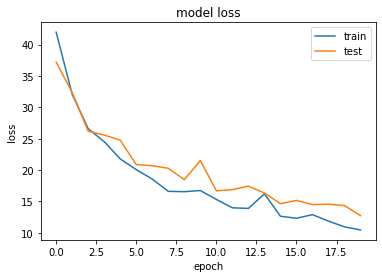

In [14]:
loss = history.history['loss']
val_loss = history.history['val_loss']

loss = np.array(loss, dtype=np.float32)
val_loss = np.array(val_loss, dtype=np.float32)

#summarize history for loss
plt.figure()
plt.plot(list(loss))
plt.plot(list(val_loss))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig("/content/drive/My Drive/Colab_Notebooks/CV_Project/loss/" + '20epochs_val_loss_12.7231.png')
plt.show()

In [15]:
model.save("/content/drive/My Drive/Colab_Notebooks/CV_Project/saved_models/val_loss_12.7231.")

CARICAMENTO DATASET

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

flow_from_dataframe mi permette di usare direttamente il csv per costruire i dataloaders

Tutorial
https://www.youtube.com/watch?v=uqomO_BZ44g&ab_channel=WhenMathsmeetscoding

https://www.youtube.com/watch?v=_L2uYfVV48I&ab_channel=deeplizard